In [1]:
import os
import sys

sys.path.append("../src")

In [2]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from copy import deepcopy
import configparser

import models
import my_eval
import severson_data
from loss_functions import nll_loss

import joblib
import random

/home/karino/miniconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_data = np.load("train.npz")
valid_data = np.load("valid.npz")
data = np.load("data.npz")

train_x, train_y, train_s = train_data["x"], train_data["y"], train_data["s"]
val_x, val_y, val_s = valid_data["x"], valid_data["y"], valid_data["s"]

In [4]:
old_x = data["old_x"]
smoothed_x = data["smoothed_x"]
augmented_data = data["augmented_data"]
y = data["y"]
train_idx = data["train_idx"]
val_idx = data["val_idx"]
test_idx = data["test_idx"]

In [5]:
config = configparser.ConfigParser()
config.read("../sample_config.ini")

save_path = config["PATHS"]["model_path_severson"]
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [6]:
batch_size = 128
num_epochs = 10
sequence_length = 100
dropout = 0
hidden_size_lstm = -1
hidden_size = 32
use_augment = 1
no_covariates = False

In [7]:
input_dim = train_x.shape[2]  # Number of input features (e.g. discharge capacity)
num_augment = train_s.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
num_models = 5  # アンサンブルするモデルの数
num_samples = 10  # 1モデルあたりのトラジェクトリ数

In [9]:
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

capacity_output_scaler = joblib.load("scaler.pkl")

In [10]:
# モデルの定義（学習時と同じアーキテクチャにする必要がある）
model_list = [
    models.Uncertain_LSTM(
        num_in=input_dim,
        num_augment=num_augment,
        num_hidden=hidden_size,
        num_hidden_lstm=hidden_size_lstm,
        seq_len=sequence_length,
        n_layers=2,
    ).to(device) for _ in range(num_models)
]
# モデルに学習済みのパラメータを入れる
for im in range(num_models):
    model_list[im].load_state_dict(torch.load(f'{save_path}/model{im}.pt'))

In [132]:
model_results = []
for im in range(num_models):
    res = joblib.load(f'{save_path}/model{im}.pkl')
    model_results.append(res)
rmse = np.array([model_results[im]["rmse_state_val"] for im in range(num_models)])
rmse

array([172.89771267, 130.08184237, 181.40903532, 124.55482633,
       122.30446007])

In [133]:
# 後で平均と標準偏差を計算する際の重みづけとする
w = 1 - (rmse - rmse.min()) / (rmse.max() - rmse.min())
w /= w.sum()
w

array([0.04841555, 0.29196804, 0.        , 0.32340775, 0.33620866])

In [25]:
max_steps = 5000

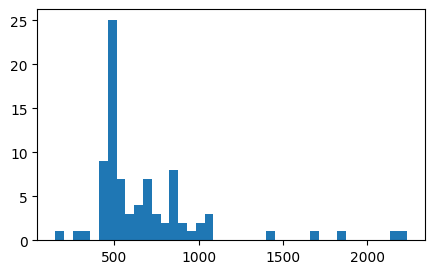

In [26]:
plt.figure(figsize=(5,3))
plt.hist(y, bins=40)
plt.show()

In [65]:
test_idx

array([77, 57, 32, 79, 59, 63, 72, 37, 29,  1, 52, 21,  2, 23, 78, 74, 20,
       60, 71, 14, 51])

In [66]:
y[test_idx]

array([ 429,  489,  648,  462,  527,  468,  535,  702,  742, 2160,  485,
        870, 2237,  860,  466,  465,  854,  495,  463,  691,  483],
      dtype=int32)

In [241]:
# model = model_list[0]  # 1個のモデルに着目
target_idx = 1  # 1個のセルに着目

# seq = old_x[[target_idx]][:, :sequence_length, None].copy()
seq = smoothed_x[[target_idx]][:, :sequence_length, None].copy()
covar = augmented_data[[target_idx]]
covar = np.hstack(
    [covar, np.ones((len([target_idx]), 1)) * np.log(sequence_length)]
)
extended_seq = np.repeat(seq, num_samples, axis=0)
extended_covar = np.repeat(covar, num_samples, axis=0)

# 初期サイクル
extended_seq = torch.from_numpy(extended_seq[:, -sequence_length:]).to(device).float()
extended_covar = torch.from_numpy(extended_covar).to(device).float()

extended_seq_list = [extended_seq for _ in range(len(model_list))]

for m in range(max_steps):  # サイクル数だけ繰り返し
    print(m)
    state_list = []
    for m_iter, model in enumerate(model_list):  # 
        model.reset_hidden_state()
        
        extended_seq = extended_seq_list[m_iter]
        (state_mean_mean, state_var) = model(extended_seq[:,-sequence_length:].to(device), extended_covar.to(device))

        if num_samples >1:
            state_mean_noisy   = state_mean_mean  +  torch.normal(0, (torch.sqrt(state_var)))  # 平均0、標準偏差state_varに従う正規分布にしたがって発生
        else:
            state_mean_noisy   = state_mean_mean

        state_mean_transformed = torch.from_numpy(capacity_output_scaler.inverse_transform(state_mean_noisy.data.cpu().numpy()))

        state_mean_transformed[:,0] = state_mean_transformed[:,0]*(extended_seq.cpu()[:, -1, 0 ] + 10e-17) # LSTMは前後比を予測してるので実測に戻す
        
        extended_seq = np.hstack((extended_seq.cpu().numpy(), state_mean_transformed.cpu().numpy()[:, None]))
        extended_seq = torch.from_numpy(extended_seq).float()
        extended_seq_list[m_iter] = extended_seq
        
    extended_covar[:,-1] = np.log(np.exp(extended_covar[:,-1].cpu())+1).to(device)
    
    final_pred = np.array([extended_seq_list[m_iter][:,-1].flatten().numpy() for m_iter in range(len(model_list))]).flatten()
    
    # if np.all(final_pred < 1e-2):
    if final_pred.mean() < 1e-2:
        break


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [242]:
# num_samples x num_modelsのトラジェクトリを得る
seq_all = extended_seq_list[0].cpu().numpy().reshape(num_samples,-1)
for n in range(1, len(model_list)):
    seq_all = np.vstack((seq_all, extended_seq_list[n].cpu().numpy().reshape(num_samples,-1)))

In [243]:
# トラジェクトリの重み付け平均を得る
mu_arr = extended_seq_list[0].cpu().numpy().reshape(num_samples,-1).mean(0)
for n in range(1, len(model_list)):
    mu_arr = np.vstack([
        mu_arr,
        extended_seq_list[n].cpu().numpy().reshape(num_samples,-1).mean(0)
    ])
mu_arr = mu_arr.T.dot(w.reshape(-1,1)).flatten()

In [244]:
# トラジェクトリの重み付け標準偏差を得る
n = 0
sigma_arr = (w[n]*(extended_seq_list[n].cpu().numpy().reshape(num_samples,-1) - mu_arr)**2).mean(0)
for n in range(1, len(model_list)):
    sigma_arr = np.vstack([
        sigma_arr,
        (w[n]*(extended_seq_list[n].cpu().numpy().reshape(num_samples,-1) - mu_arr)**2).mean(0)
    ])
sigma_arr = sigma_arr.sum(0)

In [245]:
# mu_arr = seq_all.mean(0)
# sigma_arr = seq_all.std(0)

In [246]:
# グラフ描画における透過度のパラメータ
alpha = np.repeat(rmse, num_samples)
alpha = 0.8 * (alpha - alpha.min()) / (alpha.max() - alpha.min()) + 0.2

In [247]:
alpha

array([0.88479643, 0.88479643, 0.88479643, 0.88479643, 0.88479643,
       0.88479643, 0.88479643, 0.88479643, 0.88479643, 0.88479643,
       0.30526945, 0.30526945, 0.30526945, 0.30526945, 0.30526945,
       0.30526945, 0.30526945, 0.30526945, 0.30526945, 0.30526945,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.23045945, 0.23045945, 0.23045945, 0.23045945, 0.23045945,
       0.23045945, 0.23045945, 0.23045945, 0.23045945, 0.23045945,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ])

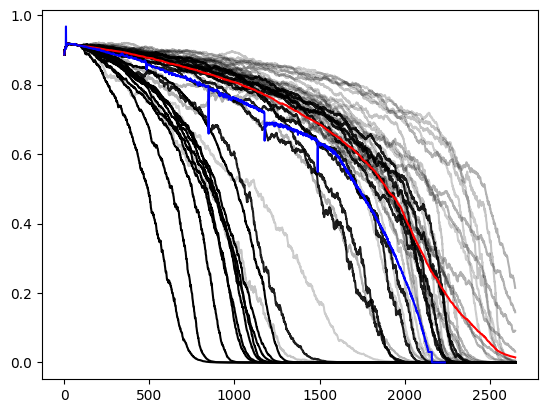

In [248]:
for n in range(seq_all.shape[0]):
        plt.plot(seq_all[n], color="k", alpha=alpha[n])
plt.plot(mu_arr, color="r")
plt.plot(old_x[target_idx], color="b")
plt.show()

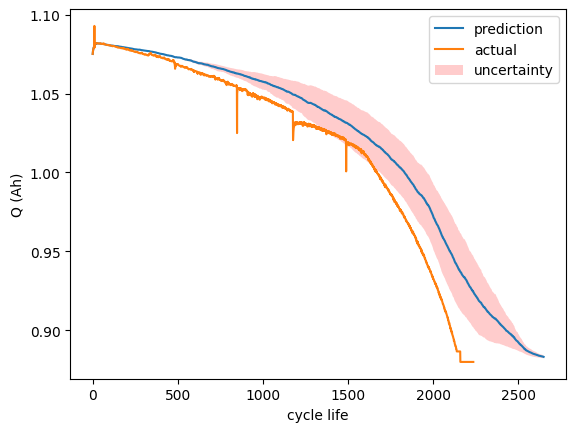

In [249]:
# lower1 = np.quantile(seq_all, 0.1/2, axis = 0) * (1.1-.8*1.1) + .8*1.1
# upper1 = np.quantile(seq_all, 1-0.1/2, axis = 0) * (1.1-.8*1.1) + .8*1.1
lower1 = (mu_arr - sigma_arr*1.96) * (1.1-.8*1.1) + .8*1.1
upper1 = (mu_arr + sigma_arr*1.96) * (1.1-.8*1.1) + .8*1.1
mean1 = mu_arr * (1.1-.8*1.1) + .8*1.1

plt.plot(mean1, label="prediction")
plt.plot(old_x[target_idx] * (1.1-.8*1.1) + .8*1.1, label="actual")

plt.fill_between(np.arange(mean1.size), upper1, lower1, facecolor="r", alpha=0.2, label="uncertainty")
plt.xlabel("cycle life")
plt.ylabel("Q (Ah)")
plt.legend()
plt.show()